In [1]:
%matplotlib inline
import nibabel as nib
import numpy as np
from scipy import ndimage
from keras import backend as K
from sklearn.metrics import accuracy_score, precision_score

from utils import *
from model_FCNN import generate_model


Using TensorFlow backend.


In [2]:
from importlib import reload

import keras
reload(keras)
from keras import backend as K

import utils
reload(utils)
from utils import *

import model_FCNN
reload(model_FCNN)
from model_FCNN import generate_model

import callback_custom
reload(callback_custom);

# Problem configuration

In [4]:
num_classes = 11
num_channel = 2

# K-fold validation (K=5)
n_training = 16
n_test = 4

#idxs_training = list(range(1, 1+16))
#idxs_test = list(range(17, 17+4))
idxs_training = list(range(1, 1+4)) + list(range(9, 9+12))
idxs_test = list(range(5,5+4))

patience = 5
model_filename = 'models/outrun_step_{}.h5'
csv_filename = 'log/outrun_step_{}.cvs'

nb_epoch = 40
validation_split = 0.10
monitor = 'val_loss'#'val_categorical_accuracy'

class_mapper = {0:0}
class_mapper.update({ i+1:i for i in range(1, 1+10) })
class_mapper_inv = {0:0}
class_mapper_inv.update({ i:i+1 for i in range(1, 1+10) })

matrix_size = (160, 220, 48)

extraction_step = (3, 3, 1)
#extraction_step = (5, 5, 3)

segment_size = (27, 27, 21)
core_size = (9, 9, 3)

# Architecture

# 1. Initial segmentation

## 1.1 Read data

In [5]:
QSM_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
MAG_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
R2S_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
label_train = np.empty(((n_training,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_training):
    QSM_train[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_train[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_train[i, :, :, :] = read_data(case_idx, 'R2S')
    label_train[i, :, :, :] = read_data(case_idx, 'label')

In [6]:
#data_train = np.stack((QSM_train, MAG_train, R2S_train), axis = 1)
data_train = np.stack((QSM_train, R2S_train), axis = 1)
#data_train = np.stack((QSM_train,), axis = 1)

In [7]:
QSM_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
MAG_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
R2S_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
label_test = np.empty(((n_test,) + matrix_size), dtype=precision_global)
for i, case_idx in enumerate(idxs_test):
    QSM_test[i, :, :, :] = read_data(case_idx, 'QSM')
    MAG_test[i, :, :, :] = read_data(case_idx, 'MAG')
    R2S_test[i, :, :, :] = read_data(case_idx, 'R2S')
    label_test[i, :, :, :] = read_data(case_idx, 'label')

In [8]:
#data_test = np.stack((QSM_test, MAG_test, R2S_test), axis = 1)
data_test = np.stack((QSM_test, R2S_test), axis = 1)
#data_test = np.stack((QSM_test,), axis = 1)

## 1.2 Pre-processing

In [9]:
## Intensity normalisation (zero mean and unit variance)
input_mean = 127.0
input_std = 128.0
data_train = (data_train - input_mean) / input_std
data_test = (data_test - input_mean) / input_std

# Map class label
tmp = np.copy(label_train)
for class_idx in class_mapper:
    label_train[tmp == class_idx] = class_mapper[class_idx]
tmp = np.copy(label_test)
for class_idx in class_mapper:
    label_test[tmp == class_idx] = class_mapper[class_idx]
del tmp

In [10]:
label_train.max()

10.0

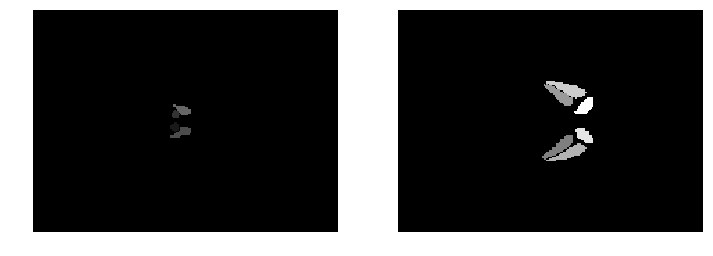

In [11]:
plots(np.squeeze(label_train[0,:,:,[29,25]]), scale = (0, 10))

## 1.3 Data preparation

In [12]:
x_train, y_train = build_set(data_train, label_train, extraction_step, segment_size, core_size)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((33401, 2, 27, 27, 21), (33401, 243, 11))

In [15]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

## 1.4 Configure callbacks

In [16]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('1'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('1'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

## 1.5 Training

In [17]:
seed = 47
np.random.seed(seed)

# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

K.set_value(model.optimizer.lr, 1e-3)

model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 30060 samples, validate on 3341 samples
Epoch 1/40
30060/30060 [==============================] - 186s 6ms/step - loss: 0.3684 - categorical_accuracy: 0.8824 - val_loss: 0.2664 - val_categorical_accuracy: 0.9226
Epoch 2/40
30060/30060 [==============================] - 185s 6ms/step - loss: 0.0845 - categorical_accuracy: 0.9653 - val_loss: 0.3606 - val_categorical_accuracy: 0.9209
Epoch 3/40
30060/30060 [==============================] - 186s 6ms/step - loss: 0.0455 - categorical_accuracy: 0.9817 - val_loss: 0.4383 - val_categorical_accuracy: 0.9236
Epoch 4/40
30060/30060 [==============================] - 186s 6ms/step - loss: 0.0382 - categorical_accuracy: 0.9858 - val_loss: 0.4179 - val_categorical_accuracy: 0.9252
Epoch 5/40
30060/30060 [==============================] - 187s 6ms/step - loss: 0.0140 - categorical_accuracy: 0.9948 - val_loss: 0.5816 - val_categorical_accuracy: 0.9267
Epoch 6/40
30060/30060 [==============================] - 188s 6ms/step - loss: 0.0113 - ca

## 1.6 Classification

In [20]:
from keras.models import load_model

# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format(1))

In [21]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

3340/3340 [==============================] - 3s 797us/step


[0.26649031562362602, 0.92253991401124147]

In [22]:
len_patch = extract_patches(read_data(1, 'QSM'), patch_shape=segment_size, extraction_step=(9, 9, 3)).shape[0]
len_patch

3300

In [23]:
segmentations_train = []

for i_case, case_idx in enumerate(idxs_training):

    print(case_idx)
    input_train = data_train[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_train[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    
    segmentations_train = segmentations_train + [segmentation]
    
segmentations_train = np.stack(segmentations_train, axis=0)

1
3300/3300 [==============================] - ETA:  - 3s 815us/step
2
3300/3300 [==============================] - 3s 766us/step
3
3300/3300 [==============================] - 3s 772us/step
4
3300/3300 [==============================] - 3s 768us/step
9
3300/3300 [==============================] - 3s 771us/step
10
3300/3300 [==============================] - 3s 774us/step
11
3300/3300 [==============================] - 3s 776us/step
12
3300/3300 [==============================] - 3s 780us/step
13
3300/3300 [==============================] - 3s 774us/step
14
3300/3300 [==============================] - 3s 789us/step
15
3300/3300 [==============================] - 3s 782us/step
16
3300/3300 [==============================] - 3s 789us/step
17
3300/3300 [==============================] - 3s 786us/step
18
3300/3300 [==============================] - 3s 785us/step
19
3300/3300 [==============================] - 3s 787us/step
20
3300/3300 [==============================] - 3s 794us/step


In [24]:
segmentations_train.max()

10.0

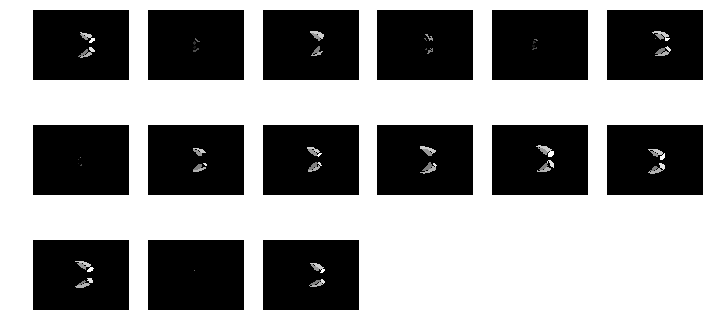

In [25]:
plots(np.squeeze(label_train[0:15,:,:,25]), rows=3, scale = (0, 10))

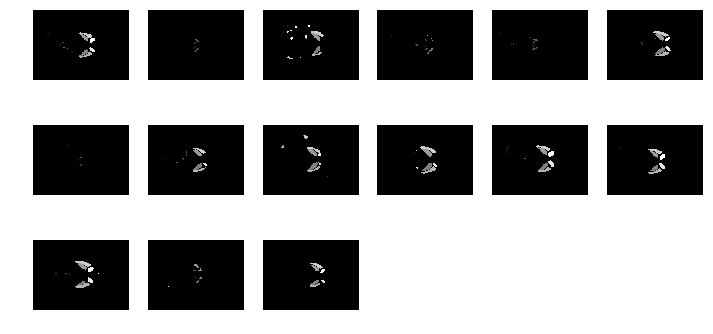

In [26]:
plots(np.squeeze(segmentations_train[0:15,:,:,25]), rows=3, scale = (0, 10))

## 1.7 Check false-positive

In [27]:
idx_fpos = (label_train == 0) & (segmentations_train != 0);

In [28]:
mask_fpos = np.zeros(label_train.shape, dtype=precision_global)
mask_fpos[idx_fpos == True] = 1

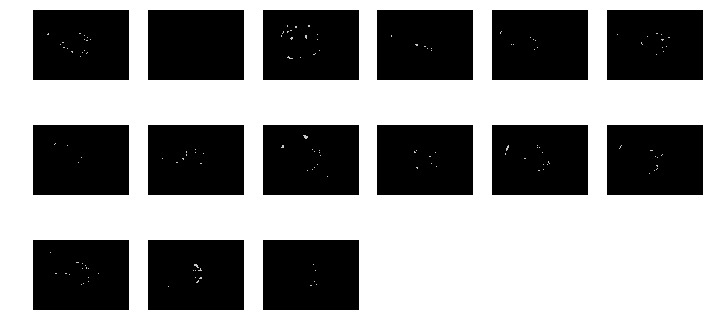

In [29]:
plots(200*(np.squeeze(mask_fpos[0:15,:,:,25])), rows=3)

# 2 Fine-tuning

## 2.2 Rebuild training dataset

In [30]:
del x_train, y_train

In [31]:
extraction_step_ft = (6,6,3)
x_train, y_train = build_set(data_train, label_train, extraction_step_ft, segment_size, core_size, mask_fpos)
x_train.shape, y_train.shape

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


((8112, 2, 27, 27, 21), (8112, 243, 11))

In [24]:
# shuffle array
idxs_shuffle = shuffle(x_train)
idxs_shuffle = shuffle(y_train, idxs_shuffle)

In [32]:
save_array('tmp/x_train.bc', x_train)
save_array('tmp/y_train.bc', y_train)

In [4]:
x_train = load_array('tmp/x_train.bc')
y_train = load_array('tmp/y_train.bc')

## 2.3 Regenerate model

In [33]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping

from callback_custom import EarlyStoppingLowLR
from callback_custom import ReduceLROnPlateauBestWeight



# Model checkpoint to save the training results
checkpointer = ModelCheckpoint(
    filepath=model_filename.format('2'),
    monitor=monitor,
    verbose=0,
    save_best_only=True,
    save_weights_only=True)

# CSVLogger to save the training results in a csv file
csv_logger = CSVLogger(csv_filename.format(1), separator=';')


stopper = EarlyStoppingLowLR(patience=patience, monitor=monitor, thresh_LR=1e-5)

learning_rate_reduction = ReduceLROnPlateauBestWeight(filepath=model_filename.format('2'),
                                                      monitor=monitor, 
                                                      patience=patience, 
                                                      verbose=1, 
                                                      factor=0.1, 
                                                      min_lr=1.001e-5)

callbacks = [checkpointer, csv_logger, learning_rate_reduction, stopper]

In [34]:
# Build model
model = generate_model(num_classes, num_channel, segment_size, core_size)

# Load optimized weights
model.load_weights(model_filename.format('1'))

K.set_value(model.optimizer.lr, 1e-4)

# Start fine-tuning
model.fit(
    x_train,
    y_train,
    epochs=nb_epoch,
    validation_split=validation_split,
    verbose=1,
    callbacks=callbacks)

# freeing space
#del x_train
#del y_train

Train on 7300 samples, validate on 812 samples
Epoch 1/40
7300/7300 [==============================] - 44s 6ms/step - loss: 0.0528 - categorical_accuracy: 0.9798 - val_loss: 0.0044 - val_categorical_accuracy: 0.9985
Epoch 2/40
7300/7300 [==============================] - 44s 6ms/step - loss: 0.0410 - categorical_accuracy: 0.9835 - val_loss: 0.0070 - val_categorical_accuracy: 0.9973
Epoch 3/40
7300/7300 [==============================] - 44s 6ms/step - loss: 0.0368 - categorical_accuracy: 0.9851 - val_loss: 0.0056 - val_categorical_accuracy: 0.9976
Epoch 4/40
7300/7300 [==============================] - 44s 6ms/step - loss: 0.0336 - categorical_accuracy: 0.9864 - val_loss: 0.0059 - val_categorical_accuracy: 0.9976
Epoch 5/40
7300/7300 [==============================] - 44s 6ms/step - loss: 0.0312 - categorical_accuracy: 0.9873 - val_loss: 0.0049 - val_categorical_accuracy: 0.9980
Epoch 6/40
7300/7300 [==============================] - 45s 6ms/step - loss: 0.0291 - categorical_accuracy: 

In [35]:
# Load best model
model = generate_model(num_classes, num_channel, segment_size, core_size)
model.load_weights(model_filename.format('2'))

In [36]:
idx_start_valid = int(len(x_train)*validation_split)
model.evaluate(x_train[-idx_start_valid:], y_train[-idx_start_valid:], verbose=1)

811/811 [==============================] - 1s 1ms/step


[0.0032079768180215567, 0.99866021179241549]

In [37]:
segmentations_test = []

for i_case, case_idx in enumerate(idxs_test):

    print(case_idx)
    input_test = data_test[i_case, :, :, :, :]

    x_test = np.zeros((len_patch, num_channel,) + segment_size, dtype=precision_global)
    for i_channel in range(num_channel):
        x_test[:, i_channel, :, :, :] = extract_patches(input_test[i_channel], patch_shape=segment_size, extraction_step=(9, 9, 3))

    pred = model.predict(x_test, verbose=1)
    pred_classes = np.argmax(pred, axis=2)
    pred_classes = pred_classes.reshape((len(pred_classes), 9, 9, 3))
    segmentation = reconstruct_volume(pred_classes, matrix_size)
    #segmentation = reconstruct_volume_majority(pred_classes, matrix_size, extraction_step=(3, 3, 3))
    
    segmentations_test = segmentations_test + [segmentation]
    
segmentations_test = np.stack(segmentations_test, axis=0)

5
3300/3300 [==============================] - 3s 798us/step
6
3300/3300 [==============================] - 3s 766us/step
7
3300/3300 [==============================] - 3s 770us/step
8
3300/3300 [==============================] - 3s 771us/step


In [38]:
segmentations_test.max()

10.0

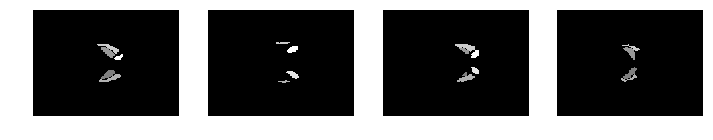

In [39]:
plots(np.squeeze(label_test[:,:,:,23]), rows=1, scale = (0, 10))

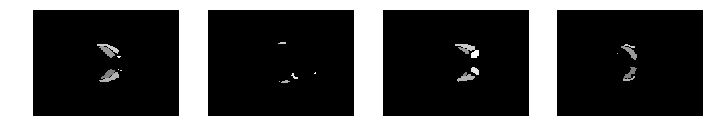

In [40]:
plots(np.squeeze(segmentations_test[:,:,:,23]), rows=1, scale = (0, 10))

# 3 Post-processing

## 3.1 Pick the largest connected component for each class

In [41]:
for i_case, case_idx in enumerate(idxs_test):
    segmentation = np.squeeze(segmentations_test[i_case,:,:,:]);
    tmp = np.zeros(segmentation.shape, dtype=segmentation.dtype)
    
    for class_idx in class_mapper_inv :
        mask = (segmentation == class_idx)
        
        if class_idx != 0 and mask.sum() > 0:
            labeled_mask, num_cc = ndimage.label(mask)
            largest_cc_mask = (labeled_mask == (np.bincount(labeled_mask.flat)[1:].argmax() + 1))
            
            tmp[largest_cc_mask == 1] = class_idx
        
    segmentations_test[i_case,:,:,:] = tmp

## 3.2 Save it 

In [42]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx)
    
    segmentation = np.copy(np.squeeze(segmentations_test[i_case,:,:,:]))
    
    tmp = np.copy(segmentation)
    for class_idx in class_mapper_inv:
        segmentation[tmp == class_idx] = class_mapper_inv[class_idx]
    del tmp

    save_data(segmentation, case_idx, 'label')    

print("Done with Step 3")

5
6
7
8
Done with Step 3


## 3.3 Calculate metric 

In [43]:
def calc_dice(m1, m2):
    return 2*((m1==1) & (m2==1)).sum()/((m1==1).sum() + (m2==1).sum())

In [44]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    print('{:.4f}'.format(accuracy_score(label_test[i_case,:,:,:].flat, segmentations_test[i_case,:,:,:].flat)), end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(precision_score(label_test[i_case,:,:,:][mask], segmentations_test[i_case,:,:,:][mask], average='micro')), end='\t')
        else:
            print('N/A', end='\t')
    print()

5	0.9993	N/A	0.8485	0.9625	0.9328	0.7902	0.9525	0.9277	0.8466	0.8701	0.6604	0.7470	
6	0.9989	N/A	0.8611	0.8400	0.9191	0.8939	0.9566	0.9776	0.9375	0.8797	0.9565	1.0000	
7	0.9993	N/A	0.9043	0.8953	0.9586	0.9462	0.9229	0.9340	0.8753	0.8675	0.8085	0.8630	
8	0.9992	N/A	0.9211	0.9077	0.9438	0.9184	0.8622	0.8275	0.9391	0.9136	0.9404	0.8632	


In [45]:
for i_case, case_idx in enumerate(idxs_test):
    print(case_idx, end='\t')
    for class_idx in class_mapper_inv:
        mask = (np.squeeze(segmentations_test[i_case,:,:,:]) == class_idx)
        if class_idx != 0 and mask.sum() > 0:
            print('{:.4f}'.format(calc_dice((label_test[i_case,:,:,:]==class_idx).flat, (segmentations_test[i_case,:,:,:]==class_idx).flat)), end='\t')
        else:
            print(0, end='\t')
    print()

5	0	0.9032	0.8603	0.6831	0.8100	0.8630	0.9197	0.8136	0.8551	0.7704	0.7178	
6	0	0.8671	0.7778	0.6667	0.7289	0.7733	0.8033	0.8320	0.8012	0.5591	0.3238	
7	0	0.8854	0.7979	0.8770	0.8571	0.9001	0.8483	0.8899	0.8238	0.7677	0.8376	
8	0	0.9150	0.7867	0.8682	0.7200	0.8853	0.8756	0.8560	0.8459	0.6296	0.6821	
